In [116]:
import math
import copy
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.special import expit as sigmoid

# Backpropagation


## A toy problem
Let's consider a binary classification problem where the task is about predict the class of a given input.

### The dataset
As a dataset, we chose a pretty standard not linearly separable dataset made of two classes "0" and "1".

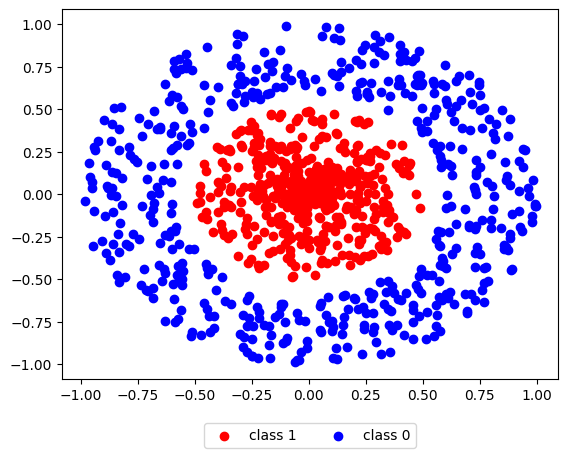

In [117]:
### code to generate datasets and visualize those

np.random.seed(0)

def generate_dataset(N_points):
    # 1 class
    radiuses = np.random.uniform(0, 0.5, size=N_points//2)
    angles = np.random.uniform(0, 2*math.pi, size=N_points//2)

    x_1 = np.multiply(radiuses, np.cos(angles)).reshape(N_points//2, 1)
    x_2 = np.multiply(radiuses, np.sin(angles)).reshape(N_points//2, 1)
    X_class_1 = np.concatenate((x_1, x_2), axis=1)
    Y_class_1 = np.full((N_points//2,), 1)

    # 0 class
    radiuses = np.random.uniform(0.6, 1, size=N_points//2)
    angles = np.random.uniform(0, 2*math.pi, size=N_points//2)

    x_1 = np.multiply(radiuses, np.cos(angles)).reshape(N_points//2, 1)
    x_2 = np.multiply(radiuses, np.sin(angles)).reshape(N_points//2, 1)
    X_class_0 = np.concatenate((x_1, x_2), axis=1)
    Y_class_0 = np.full((N_points//2,), 0)

    X = np.concatenate((X_class_1, X_class_0), axis=0)
    Y = np.concatenate((Y_class_1, Y_class_0), axis=0)
    return X, Y

N_points = 1000
X, Y = generate_dataset(N_points)

plt.scatter(X[:N_points//2, 0], X[:N_points//2, 1], color='red', label='class 1')
plt.scatter(X[N_points//2:, 0], X[N_points//2:, 1], color='blue', label='class 0')
plt.legend(loc=9, bbox_to_anchor=(0.5, -0.1), ncol=2)
plt.show()

### The neural network
As we can see from the dataset above, the data point are defined as $
\begin{equation}
    \begin{split}
        \mathbf{x} =
                        \begin{bmatrix}
                            x_1 \\
                            x_2 \\
                        \end{bmatrix}
    \end{split}
\end{equation}
$. Therefore the input layer of the network must have two units. We want to classify the data points as being either class "1" or class "0", then the output layer of the network must contain a single unit. Between the input and the output layers, we add a hidden layer with 3 units. The full network looks like:

<img style="width: 600px;" src="static/images/neural_network_practice.png">

Choosing the right network architecture is more an art than a science, and there is no ground reason to choose the second layer to have 3 units. I encourage you to go and play with the [tensorflow playground](https://playground.tensorflow.org/#activation=tanh&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=0&networkShape=4,2&seed=0.07489&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false) to realize that. We have already studied a similar architecture before but with a single unit per layer. The previous equations can be easily generalized for layers with more than one unit:


$ \mathbf{z_1} = \mathbf{W_1 x} + \mathbf{b_1} $,  with
$
\begin{equation}
    \begin{split}
        \mathbf{W_1} =
                        \begin{bmatrix}
                            w^{(1)}_{1,1}       & w^{(1)}_{2,1} \\
                            w^{(1)}_{1,2}       & w^{(1)}_{2,2} \\
                            w^{(1)}_{1,3}       & w^{(1)}_{2,3} \\
                        \end{bmatrix}
    \end{split}
\end{equation}
$,
$
\begin{equation}
    \begin{split}
        \mathbf{x} =
                        \begin{bmatrix}
                            x_1 \\
                            x_2 \\
                        \end{bmatrix}
    \end{split}
\end{equation}
$ and
$
\begin{equation}
    \begin{split}
        \mathbf{b_1} =
                        \begin{bmatrix}
                            b^{(1)}_{1}\\
                            b^{(1)}_{2}\\
                            b^{(1)}_{3}\\
                        \end{bmatrix}
    \end{split}
\end{equation}
$


$ \mathbf{h} = \sigma(\mathbf{z_1}) $

$ \mathbf{z_2} = \mathbf{W_2 h} + b_2$ with
$
\begin{equation}
    \begin{split}
        \mathbf{W_2} =
                        \begin{bmatrix}
                            w^{(2)}_{1,1}       & w^{(2)}_{2,1}       & w^{(2)}_{3,1}
                        \end{bmatrix}
    \end{split}
\end{equation}
$, and $b_2 = b^{(2)}_1$.

$ \mathbf{y} = \sigma(\mathbf{z_2}) $

The above equations allow to predict a single output given a single data point$
\begin{equation}
    \begin{split}
        \mathbf{x} =
                        \begin{bmatrix}
                            x_1 \\
                            x_2 \\
                        \end{bmatrix}
    \end{split}
\end{equation}
$. Instead of looping over all the data points from the dataset and evaluation y from them, it is way more efficient to take advantage of the vectorization of the problem. Let's consider the vector $\mathbf{X}$ with the shape $(N_{points}, 2)$:
$
\begin{equation}
    \begin{split}
        \mathbf{X} =
                        \begin{bmatrix}
                            x_1^{(1)}    &    x_2^{(1)} \\
                            x_1^{(2)}    &    x_2^{(2)} \\
                            . & . \\                           
                            . & . \\                           
                            . & . \\                           
                            x_1^{(N_{points})}    &    x_2^{(N_{points})} \\
                        \end{bmatrix}
    \end{split}
\end{equation}
$

where the upperscripts $^{(i)}$ simply refer to the datapoints.

We can rewrite the equations vectorized:


$ \mathbf{Z_1} = \mathbf{X W_1^T} + \mathbf{1 b_1^T} $, with
$
\begin{equation}
    \begin{split}
        \mathbf{1} =
                        \begin{bmatrix}
                            1 \\
                            1 \\
                            . \\                           
                            . \\                           
                            . \\                           
                            1 \\
                        \end{bmatrix}
    \end{split}
\end{equation}
$ a vector of shape $(N_{points}, 1)$ whose elements are all 1.

$ \mathbf{H} = \sigma(\mathbf{Z_1}) $

$ \mathbf{Z_2} = \mathbf{H W_2^T} + \mathbf{1} b_2$, with $\mathbf{1}$ is as defined above.

$ \mathbf{Y} = \sigma(\mathbf{Z_2}) $

### Forward propagation
Let's now implement the code for the forward propagation through the network.

In [136]:
weights = {
    'W1': np.random.randn(3, 2),
    'b1': np.zeros((3)),
    'W2': np.random.randn(3),
    'b2': 0,
}
def forward_propagation(X, weights):
    W1,b1,W2,b2 = weights['W1'], weights['b1'], weights['W2'], weights['b2']
    # b1=b1.reshape(1,-1)
    # print(b1.shape)
    # print(np.dot(X,W1.T)[0])
    # print((np.dot(X,W1.T)+b1)[0])
    Z1=np.dot(X, W1.T) + b1
    H=sigmoid(Z1)
    Z2=np.dot(H, W2.T) + b2
    # print(Z2.shape)
    Y=sigmoid(Z2)
    forward_cache = {
        "Z1" : Z1,
        "Z2" : Z2,
        "H" : H,
        "Y" : Y
    }
    return forward_cache


output=(forward_propagation(X,weights))
output['Y'].shape

(1000,)

### Loss function
Previously, for simplicity we used the squared error as a loss function. It turns out that for a classification problem, this is not an appropriate choice as a loss function. Indeed the squared error is not able to distinguish bad prediction from extremely bad ones in a classification context. Here as a loss function, we will rather use the cross entropy function defined as:

$L(y, y_T) = \frac{1}{N_{points}} \sum_{n=1}^{N_{points}}\left( -y_T^{(n)} \log(y^{(n)}) - (1-y_T^{(n)}) \log(1-y^{(n)})\right) $

where $y^{(n)}$ is the output of the forward propagation of a single data point
$
\begin{equation}
    \begin{split}
        \mathbf{x^{(n)}} =
                        \begin{bmatrix}
                            x^{(n)}_1 \\
                            x^{(n)}_2 \\
                        \end{bmatrix}
    \end{split}
\end{equation}
$, and $y_T^{(n)}$ the correct class of the data point.


To understand why the cross entropy is a good choice as a loss function, I highly recommend this [video from Aurelien Geron](https://www.youtube.com/watch?v=ErfnhcEV1O8).


### Backpropagation
We have everything we need now to define the back_propagation function. First let's write again down the gradient equations:

$ \frac{\partial L}{\partial \mathbf{W_2}} = \frac{\partial L}{\partial \mathbf{Y}}\frac{\partial \mathbf{Y}}{\partial \mathbf{Z_2}}\frac{\partial \mathbf{Z_2}}{\partial \mathbf{W_2}}$

$ \frac{\partial L}{\partial \mathbf{b_2}} = \frac{\partial L}{\partial \mathbf{Y}}\frac{\partial \mathbf{Y}}{\partial \mathbf{Z_2}}\frac{\partial \mathbf{Z_2}}{\partial \mathbf{b_2}}$

$ \frac{\partial L}{\partial \mathbf{W_1}} = \frac{\partial L}{\partial \mathbf{Y}}\frac{\partial \mathbf{Y}}{\partial \mathbf{Z_2}}\frac{\partial \mathbf{Z_2}}{\partial \mathbf{H}}\frac{\partial \mathbf{H}}{\partial \mathbf{Z_1}}\frac{\partial \mathbf{Z_1}}{\partial \mathbf{W_1}}$

$ \frac{\partial L}{\partial \mathbf{b_1}} = \frac{\partial L}{\partial \mathbf{Y}}\frac{\partial \mathbf{Y}}{\partial \mathbf{Z_2}}\frac{\partial \mathbf{Z_2}}{\partial \mathbf{H}}\frac{\partial \mathbf{H}}{\partial \mathbf{Z_1}}\frac{\partial \mathbf{Z_1}}{\partial \mathbf{b_1}}$

We therefore need the following partial derivatives, which can be easily obtained:

$ \frac{\partial L}{\partial\mathbf{Y}} = \frac{1}{N} \frac{\mathbf{Y}-\mathbf{Y_T}}{\mathbf{Y}(1-\mathbf{Y})}$

$ \frac{\partial \mathbf{L}}{\partial\mathbf{Z_2}} = \frac{\partial L}{\partial\mathbf{Y}} .\left(\sigma(\mathbf{Z_2})(1-\sigma(\mathbf{Z_2}))\right)$

$ \frac{\partial \mathbf{L}}{\partial \mathbf{W_2}} = \mathbf{H^T} \frac{\partial \mathbf{L}}{\partial\mathbf{Z_2}}$

$ \frac{\partial \mathbf{L}}{\partial \mathbf{b_2}} = \left(\frac{\partial \mathbf{L}}{\partial\mathbf{Z_2}} \right)^T\mathbf{1}$

$ \frac{\partial \mathbf{L}}{\partial \mathbf{H}} = \frac{\partial \mathbf{L}}{\partial\mathbf{Z_2}} \mathbf{W_2^T}$

$ \frac{\partial \mathbf{L}}{\partial \mathbf{Z_1}} = \frac{\partial \mathbf{L}}{\partial \mathbf{H}}.\left(\sigma(\mathbf{Z_1})(1-\sigma(\mathbf{Z_1}))\right)$

$ \frac{\partial \mathbf{L}}{\partial \mathbf{W_1}} = \left(\frac{\partial \mathbf{L}}{\partial \mathbf{Z_1}}\right)^T\mathbf{X}$

$ \frac{\partial \mathbf{L}}{\partial \mathbf{b_1}} = \left(\frac{\partial \mathbf{L}}{\partial \mathbf{Z_1}}\right)^T\mathbf{1}$

We can now define the code for the backpropagation:

In [138]:
def crossentropyloss(N, Y_T,Y):
  return (1/N) * np.sum(-Y_T * np.log(Y) - (1 - Y_T) * np.log(1 - Y))

In [137]:
def back_propagation(X, Y_T, weights):
    N_points = X.shape[0]

    # forward propagation
    vals=forward_propagation(X,weights)
    Y, Z2, H, Z1 = vals['Y'] , vals['Z2'] , vals['H'] , vals['Z1']
    L = crossentropyloss(N_points, Y_T, Y)
    # back propagation
    #.....................# calculate dLdW2
    dLdW2=np.dot(H.T,(1/N_points * (Y-Y_T))).reshape(3,)
    #.....................# calculate dLdb2
    iid=np.ones((1000,1))
    dLdb2=np.dot(1/N_points * (Y-Y_T).T  , iid)
    #.....................# calculate dLdW1
    dLdH=np.dot((1/N_points * (Y-Y_T)).reshape(1,-1).T,weights['W2'].reshape(1,-1))
    dLdW1=np.dot((dLdH * (H) * (1-H)).T,X)
    #.....................# calculate dLdb1
    dLdb1=np.dot((dLdH * (H) * (1-H)).T,iid).reshape(3,)


    gradients = {
        'W1': dLdW1,
        'b1': dLdb1,
        'W2': dLdW2,
        'b2': dLdb2,
    }
    return gradients, L

output,l=back_propagation(X,Y,weights)
print(output['W1'].shape)
print(output['b1'].shape)
print(output['W2'].shape)
print(output['b2'].shape)

(3, 2)
(3,)
(3,)
(1,)


### Training: gradient descent
We have all in place to start training our network using gradient descent. Remember, at every iteration the weights and the biases are updated as $ w^{(n+1)} = w^{(n)} - \epsilon \frac{\partial L}{\partial w} $.

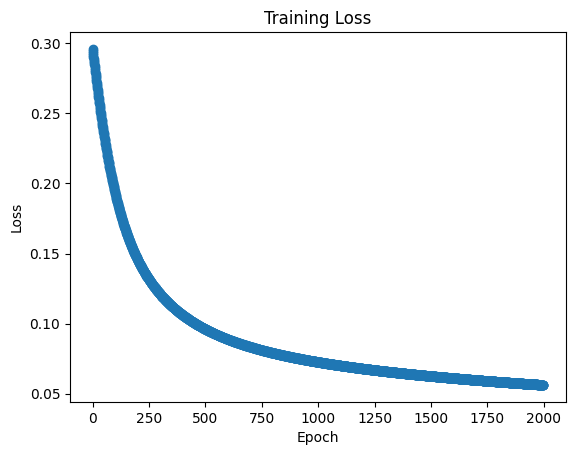

In [145]:
epochs = 2000
epsilon = 1
initial_weights = copy.deepcopy(weights)

losses = []
for epoch in range(epochs):
  gradients, L = back_propagation(X, Y, weights)
  for weight_name in weights:
    # print(weights[weight_name].shape)
    # print(weights['W1'].shape)
    #..................... # fill here following the update rule for gradient descent
    weights[weight_name] -= epsilon * gradients[weight_name]



  losses.append(L)

plt.scatter(range(epochs), losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

As we can see in the plot above where the loss is plotted with respect to the number of epochs the network experienced, we clearly observed a decrease of the loss. In other words, the network seems to make less and less errors. In other words, it learns something.

### Visualize what the network learned
Before to see what the network learned, it would be interesting to see how the initial weights of the network would perform.

In [146]:
def visualization(weights, X_data, title, superposed_training=False):
    N_test_points = 1000
    xs = np.linspace(1.1*np.min(X_data), 1.1*np.max(X_data), N_test_points)
    datapoints = np.transpose([np.tile(xs, len(xs)), np.repeat(xs, len(xs))])
    Y_initial = forward_propagation(datapoints, weights)['Y'].reshape(N_test_points, N_test_points)
    X1, X2 = np.meshgrid(xs, xs)
    plt.pcolormesh(X1, X2, Y_initial)
    plt.colorbar(label='P(1)')
    if superposed_training:
        plt.scatter(X_data[:N_points//2, 0], X_data[:N_points//2, 1], color='red')
        plt.scatter(X_data[N_points//2:, 0], X_data[N_points//2:, 1], color='blue')
    plt.title(title)
    plt.show()

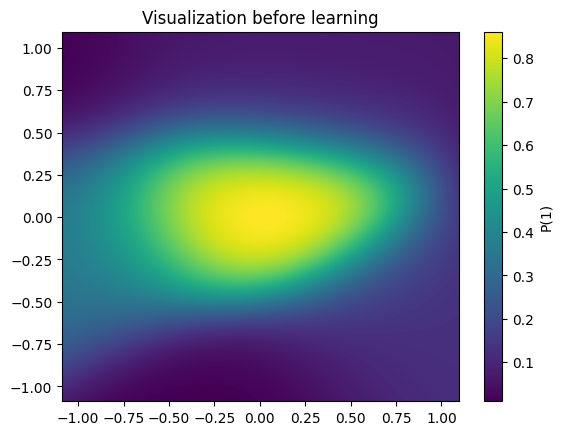

In [147]:
visualization(initial_weights, X,  'Visualization before learning')

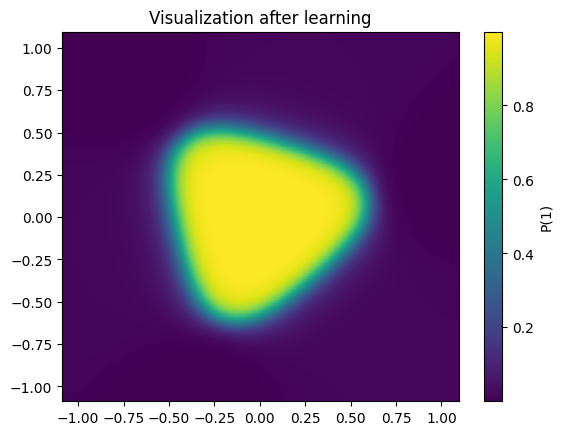

In [148]:
visualization(weights, X, 'Visualization after learning')

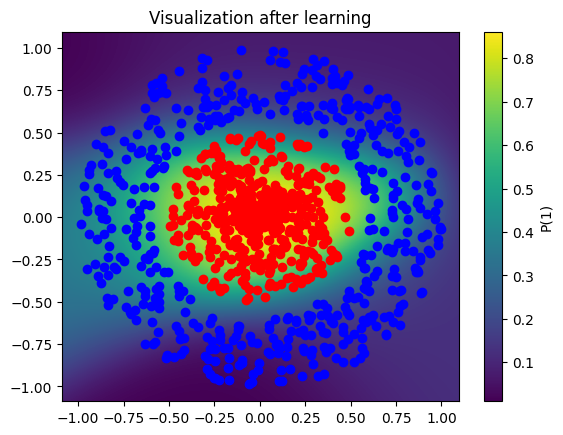

In [143]:
visualization(weights, X, 'Visualization after learning', superposed_training=True)

### With a XOR like distribution
Let's try our implementation with another distribution.

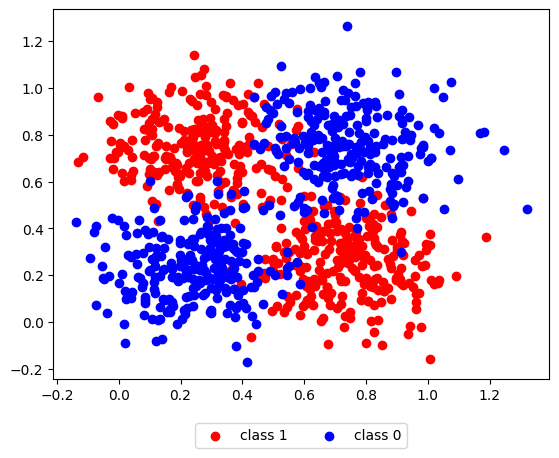

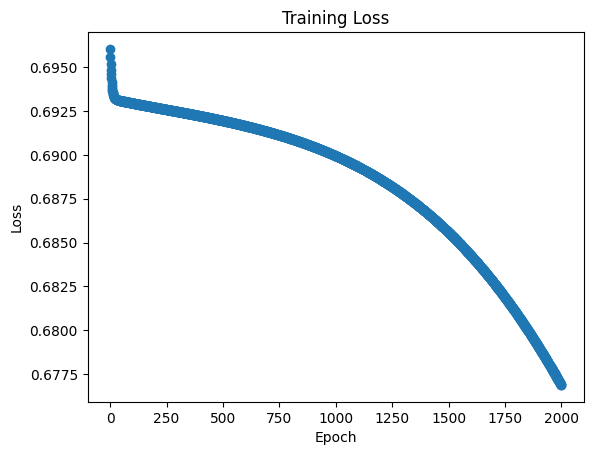

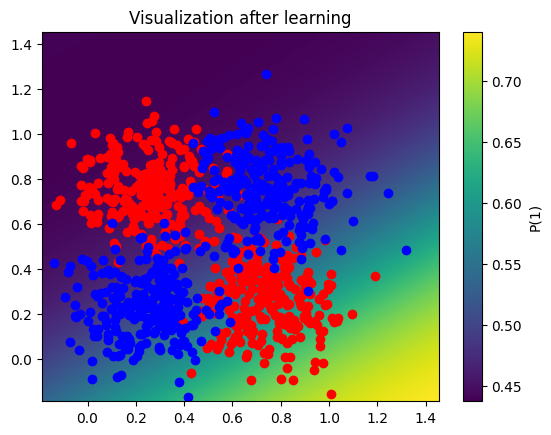

In [144]:
def generate_xor_like_dataset(N_points):
    # 1 class
    X_class_1 = np.concatenate(
        (np.concatenate(
            (np.random.normal(0.25, 0.15, size=N_points//4).reshape(N_points//4,1),
             np.random.normal(0.75, 0.15, size=N_points//4).reshape(N_points//4,1)),
            axis=1),
        np.concatenate(
            (np.random.normal(0.75, 0.15, size=N_points//4).reshape(N_points//4,1),
             np.random.normal(0.25, 0.15, size=N_points//4).reshape(N_points//4,1)),
            axis=1))
    )
    Y_class_1 = np.full((N_points//2,), 1)

    # 0 class
    X_class_0 = np.concatenate(
        (np.concatenate(
            (np.random.normal(0.25, 0.15, size=N_points//4).reshape(N_points//4,1),
             np.random.normal(0.25, 0.15, size=N_points//4).reshape(N_points//4,1)),
            axis=1),
        np.concatenate(
            (np.random.normal(0.75, 0.15, size=N_points//4).reshape(N_points//4,1),
             np.random.normal(0.75, 0.15, size=N_points//4).reshape(N_points//4,1)),
            axis=1))
    )
    Y_class_0 = np.full((N_points//2,), 0)

    X = np.concatenate((X_class_1, X_class_0), axis=0)
    Y = np.concatenate((Y_class_1, Y_class_0), axis=0)
    return X, Y

xor_X, xor_Y = generate_xor_like_dataset(N_points)

plt.scatter(xor_X[:N_points//2, 0], xor_X[:N_points//2, 1], color='red', label='class 1')
plt.scatter(xor_X[N_points//2:, 0], xor_X[N_points//2:, 1], color='blue', label='class 0')
plt.legend(loc=9, bbox_to_anchor=(0.5, -0.1), ncol=2)
plt.show()

xor_weights = {
    'W1': np.random.randn(3, 2),
    'b1': np.zeros(3),
    'W2': np.random.randn(3),
    'b2': 0,
}
xor_initial_weights = copy.deepcopy(xor_weights)
xor_losses = []
for epoch in range(epochs):
    gradients, L = back_propagation(xor_X, xor_Y, xor_weights)
    for weight_name in xor_weights:
        xor_weights[weight_name] -= epsilon * gradients[weight_name]

    xor_losses.append(L)

plt.scatter(range(epochs), xor_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

visualization(xor_weights, xor_X, 'Visualization after learning', superposed_training=True)

## Conclusion
As a conclusion, backpropagation is not an extremely complicated algorithm, and as we have seen above, it is pretty straightforward to derive a bare numpy implementation for it. Although it comes out of the box with most of the deep learning frameworks, it is a good idea to get your hands dirty and understand a little bit more what it does. In some occasions, it might help you understand why your network is not learning properly.